# Marathon results and pacing
## A look into Scotiabank Toronto Waterfront Marathon 2017 results

*Analytic Report and Research Proposal*

Author: Martin Odendaal

Soure: [Sportstats](https://www.sportstats.ca/display-results.xhtml?raceid=43500)

## Introduction

On a bright morning in October 2017 close to 4,000 runners stood at the starting line for the Scotiabank Toronto Waterfront Marathon. While some runners just hoped to finish, others had decided on a goal time for their race.  A goal time is set by taking previous race times, training, and course conditions into account... and then overriding these factors with great dollops of myopia. You have to be an optimist to stare at a 42.2km route and think it's going to go well, but maybe there is also something to be learnt about what to expect from results data of a marathon.

In this report I analyse the results of the 2017 Scotiabank Toronto Waterfront Marathon across three broad dimensions. First, I analyze the how the marathon results vary by age and sex. While runners are ranked based on their overall finish time, they are also split into subcategories based on age and sex. These subcategories are often viewed as a fairer reflection of a runner's result and many of the prestigious races (e.g. Boston marathon) have entry requirements based these subcategories. 

Second, I investigate the extent to which runners can maintain an even pace throughout the marathon. A marathon has various check points (timing mats) throughout the race that can be used to calculate a runner’s pace over a particular ‘split’ (generally 5km or 10km intervals). Runners often use their goal time and then work backwards to calculate a race pace which will allow them to meet this target. However, many runners rely on pacing charts which assume an even-pacing strategy. In practice this is difficult to achieve. Race-day excitement often leads to quick starts, while overambitious targets, the weather, and poor nutrition and water consumption can lead to runners slowing down in the latter end of the race. The race course can also affect runners’ pacing at various stages of the race, but this is not a factor for Scotiabank Toronto Waterfront Marathon which is relatively flat as shown in the figure below (the scale on the y-axis is somewhat deceiving, the 15m gain in elevation over the first 3km is still a very mild slope).

Third, I analyze to what extent top runners’ pacing differs from the average runner. Here, top runners are defined as anyone able to complete the marathon in less than 3 hours. The similarities and differences between the results from the overall population and the top runners sample can be instructive for future runners.

The final section of this report provides some ideas for future research.

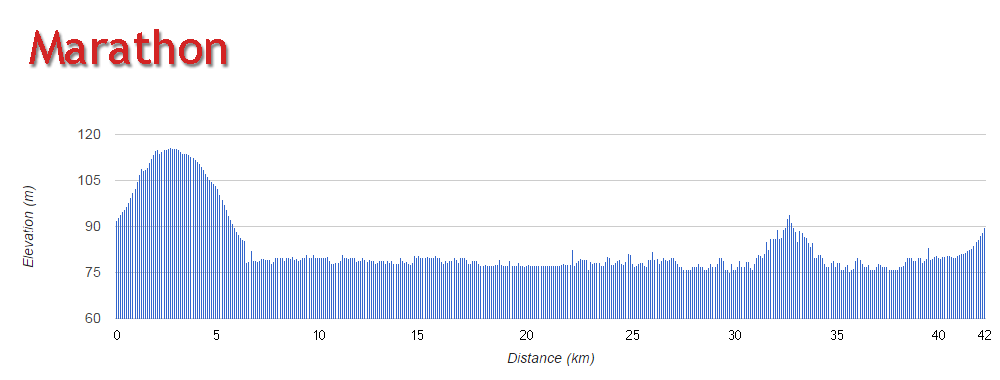

Source: [Course elevation](https://www.racepoint.ca/maps/images/stwm-marathon-elevations.png)

## Setting up the data

The data consists of all the finishers of the Scotiabank Toronto Waterfront Marathon in 2017 (3,959 runners). Each runner's name, bib number, country, and category (a combination of their age-bracket and sex) is recorded and matched to their results in terms of overall rank, gender rank, category rank, time at kilometer 10, time at kilometer 21.1, time at kilometer 30, and the finishing time at 42.2km.

The data is imported from an excel file and read into a panda dataframe. While panda does have some functionality to deal with time, the easiest way is to convert all time measures to minutes. Using seconds would be more accurate (and avoids confusion of understanding what the minute decimal refers to), but minutes are preferred as this easier to read.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import datetime as dt
import seaborn as sns
from scipy.stats import ttest_ind

In [7]:
# Reading the excel file
toronto = pd.read_excel('torontoMarathon.xlsx', sheet_name='Sheet1')
toronto.head(3)

,Bib,Name,Country,Category,Rank,Gender_Place,Cat. Place,Split10km,Split21km,Split30km,Official_time
0,1,Philemon Rono,KEN,M25-29,1,1.0,1,00:29:31,01:02:38,01:29:29,02:06:52
1,2,Dickson Chumba,KEN,M30-34,2,2.0,1,00:29:31,01:02:38,01:29:29,02:09:11
2,3,Solomon Deksisa,ETH,M18-24,3,3.0,1,00:29:31,01:02:37,01:30:08,02:11:24.600000


In [8]:
# Renaming columns to avoid confusion later.
toronto.rename(columns = {'Official_time':'Total_time', 'Split10km':'Time10km',
                          'Split21km':'Time21km', 'Split30km':'Time30km'}, inplace=True)

# Remove all NaN from sample (e.g. if timing mat didn't work or if the runner skipped the mat - cheater!)
initial_obs = len(toronto.index)
toronto.dropna(subset=['Time10km', 'Time21km', 'Time30km', 'Total_time'], inplace=True)
dropped_obs = initial_obs - len(toronto.index)
print("{} values were removed. The new sample size is now {}".format(dropped_obs, len(toronto.index)))

31 values were removed. The new sample size is now 3928


In [9]:
#Transform datetime.time columns to total seconds (int)
torontoSec = toronto[['Total_time', 'Time10km', 'Time21km', 'Time30km']].applymap(lambda x:
                                                                                  ((x.hour*60+x.minute)*60+x.second))
torontoSec.rename(columns = {'Total_time': 'Total_timeS',
                             'Time10km': 'Time10kmS',
                             'Time21km':'Time21kmS',
                             'Time30km':'Time30kmS'}, inplace = True)

#Add in minutes columns for graphs for easier comprehension
#NOTE: The decimals of minutes will not refer to seconds!
torontoMin = torontoSec[['Total_timeS', 'Time10kmS', 'Time21kmS', 'Time30kmS']].applymap(lambda x: x/60)
torontoMin.rename(columns = {'Total_timeS': 'Total_time_Min',
                             'Time10kmS': 'Time10km_Min',
                             'Time21kmS':'Time21km_Min',
                             'Time30kmS':'Time30km_Min'}, inplace = True)

#Concatenate the datasets
torontoS = pd.concat([toronto, torontoSec, torontoMin], axis=1)

#Create a column to split the sample into male and female
torontoS['Male'] = toronto['Category'].str.contains('M')

#Splitting into male and female samples
maleOnly = torontoS[torontoS['Male'] == True]
femaleOnly = torontoS[torontoS['Male'] == False]

#Creating series.array to plot with
m_finTime = maleOnly['Total_time_Min']
f_finTime = femaleOnly['Total_time_Min']
type(m_finTime)

pandas.core.series.Series

## How much do finish times vary between age and sex?

Runners rely on various subcategories to check their results against similar runners. This section analyses whether the results differed across these categories.

The first split is among men and women. There were 2,554 males who completed the marathon compared to 1,374 females. Men, on average, finished the marathon in 253 minutes (or 4 hours 13 minutes), about 22 minutes quicker than the female average. This difference is highly significant (with a t-stat of -13.59). Note that this distribution may not hold for other races or even for the Toronto marathon over time. See the Future Research section below for some proposals on how to address this.

The histogram below shows the distribution of the two samples.


In [10]:
print("{} men participated and their average finish time was {} minutes".format(
    len(maleOnly.index), round(m_finTime.mean(),1)))
print("{} females participated and their average finish time was {} minutes".format(
    len(femaleOnly.index), round(f_finTime.mean(),1)))

2554 men participated and their average finish time was 253.6 minutes
1374 females participated and their average finish time was 275.2 minutes


In [11]:
print(ttest_ind(m_finTime, f_finTime, equal_var=False))

Ttest_indResult(statistic=-13.590646314594064, pvalue=8.710911822361324e-41)


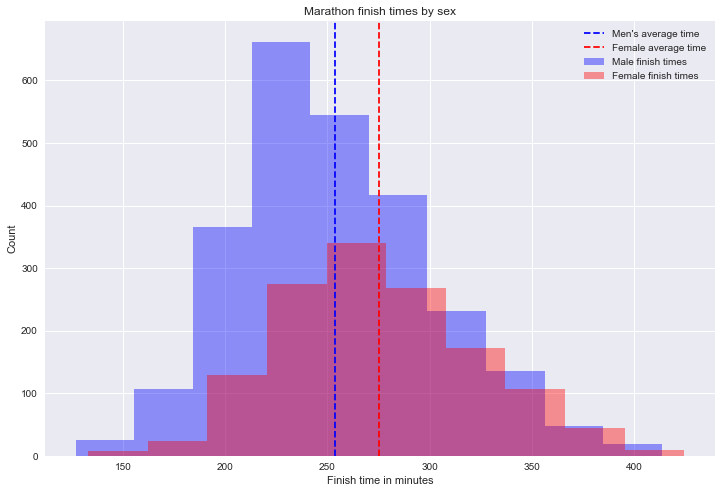

In [12]:
# Plotting male and female results
plt.figure(figsize = (12,8))
plt.hist(m_finTime, alpha = 0.4, color = 'b', label='Male finish times')
plt.hist(f_finTime, alpha = 0.4, color = 'r', label='Female finish times')
plt.ylabel("Count")
plt.axvline(m_finTime.mean(), label = 'Men\'s average time', color='b', linestyle = 'dashed')
plt.axvline(f_finTime.mean(), label = 'Female average time', color='r', linestyle = 'dashed')
plt.xlabel('Finish time in minutes')
plt.title('Marathon finish times by sex')
plt.legend()
plt.show()

The difference in results seems to be driven by the competitiveness of the top male runners. In the top 200 finishers only 26 were women (the 200th runner finished with a time of 03:09:17 or 189 minutes). Even though there are more men than women running (by almost 2:1), this is still an underrepresentation.  However, as the times get slightly slower women become much better represented. In the top 500 finishers (below 03:28:07 or 218 minutes) there are 80 women. 

Next, I investigate the extent to which the results differed by age, while also keeping the male/ female categories. The (admittedly busy) boxplot below shows how the distributions of the age categories differ.  

<class 'pandas.core.series.Series'>


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


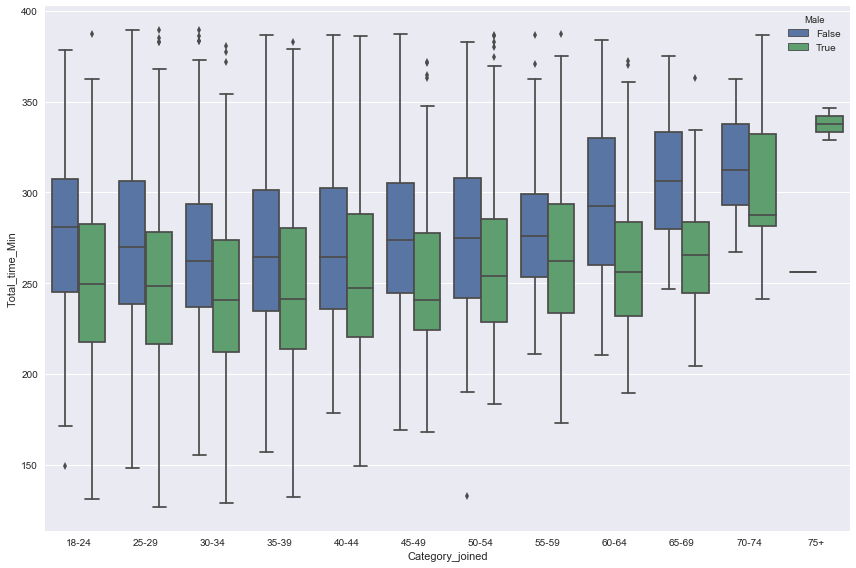

In [13]:
# Split datasets for plotting 
categoryTime = torontoS[['Category', 'Total_time_Min', 'Male']]

# Joining male and female categories for factor plot
category_join = list(torontoS['Category'])
category_all = []
for i in range(len(category_join)):
    stringtoList = list(category_join[i])
    category_all.append(''.join(stringtoList[1:]))

# Convert to pd series to set factors as categorical 
category_pd = pd.Series(category_all, dtype="category")
print(type(category_pd))
category_pd = category_pd.cat.set_categories(['18-24', '25-29', '30-34','35-39', '40-44',
                                  '45-49', '50-54','55-59','60-64',
                                  '65-69', '70-74','75+'], ordered=True)


# Joining new category to dataset
categoryTime['Category_joined'] = category_pd

# Plotting with seaborn
sns.set_style("darkgrid")
sns.factorplot(kind='box',
               y='Total_time_Min',
               x='Category_joined',
               hue='Male',         
               data=categoryTime,   
               size=8,                  
               aspect=1.5,         
               legend_out=False)      

There are lots of interesting aspects to this boxplot.
- The men/ women category shows significant differences within age categories. These inter-age differences are relatively stable for younger runners, but for runners over 60 the distribution of male and female finish times becomes more divergent (although the sample sizes are also getting smaller). 
- For male and females the finish time distribution is relatively similar across the age category up until about 50 (i.e. the distribution for men between 18-24 is relatively similar to men 45-49). While this may imply that these categories are not particularly useful it should be remembered that (a) this pattern may not hold over time or across races and (b) the categories are set to indicate a good time which does change over age (for example the finish times of the category winners  - the lower bar at the end of the whisker - does increase over the age categories). For the average marathon runner this finding may provide some comfort that growing old may not be so bad after all (only to discover that the sample of older runners is biased – we only get to see the ones who didn’t get injured!).
-  Men seem to have more outliers at the slow end of the distribution which may increase the mean. Stubbornness can sometimes get you a medal at the finish line (and a banana!). 


## How does pacing change throughout the marathon?

Choosing the correct pace to run is critical in race performance. Start too fast and you are likely to tire by the end of the race (what runners call ‘hitting the wall’). Start too slow and you might not be able to make up time in the end. Most runners aim for a constant pace throughout the marathon, while some even hope for the mythical negative split (running the second half of the marathon faster than the first).

To test runners’ pacing on race day I calculate the pace during various segments of the race (0 – 10km, 10 - 21.1km, 21.1 – 30km, and 30 – 42.2km). These pace calculations are transformed into an index for easier comprehension using the overall average pace of the individual runner (i.e. her finish time / 42.2). A score below 100 shows indicates a faster than average pace.

The figure below shows the average pace times for the marathon.

In [14]:
# Calculate splits (time between mats)
torontoS['Split10kmS'] = torontoS['Time10kmS']
torontoS['Split21kmS'] = torontoS['Time21kmS'] - torontoS['Time10kmS']
torontoS['Split30kmS'] = torontoS['Time30kmS'] - torontoS['Time21kmS']
torontoS['Split42kmS'] = torontoS['Total_timeS'] - torontoS['Time30kmS']

# Overall averge pace
totalPace = torontoS['Total_timeS'].mean()/42.2

xaxis = np.array([10, 21.1, 30, 42.2])

# Rebase pace against individual total average pace for easier visuals and understanding (total average pace = 100)
torontoS['Index10'] = (torontoS['Split10kmS']/10) / (torontoS['Total_timeS']/42.2) * 100
torontoS['Index21'] = (torontoS['Split21kmS']/11.1) / (torontoS['Total_timeS']/42.2) * 100
torontoS['Index30'] = (torontoS['Split30kmS']/8.9) / (torontoS['Total_timeS']/42.2) * 100
torontoS['Index42'] = (torontoS['Split42kmS']/12.2) / (torontoS['Total_timeS']/42.2) * 100

# Calculate average index for all runners
avgPace_index = np.array([torontoS['Index10'].mean(),
                    torontoS['Index21'].mean(),
                    torontoS['Index30'].mean(),
                    torontoS['Index42'].mean()])

avgPace_index

array([  92.00425181,   93.90938493,  101.92781112,  110.6889992 ])

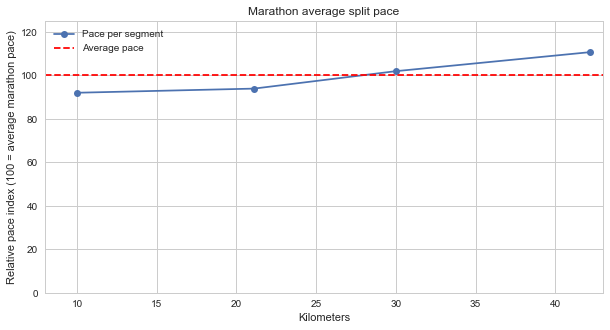

In [15]:
plt.figure(figsize=(10,5))
plt.style.use('seaborn-whitegrid')
plt.plot(xaxis, avgPace_index, marker = 'o', label = 'Pace per segment')
plt.ylabel("Relative pace index (100 = average marathon pace)")
plt.ylim([0, 125])
plt.xlim([8,43])
plt.axhline(y = 100, label = 'Average pace', color='r', linestyle = 'dashed',)
plt.xlabel('Kilometers')
plt.title('Marathon average split pace')
plt.legend()
plt.show()

Marathon runners are optimists at heart. On average runners start too fast - getting caught up in the excitement of the race or overestimating their ability to maintain a certain pace. But reality sets in at the 30km mark. As the crowds thin and the initial euphoria fades there is still a quarter of the race left with only tired legs and a chafing shirt. On average runners end almost 10% slower than their average race pace. 

## Do strong runners using different pacing strategies?

Do all marathon runners start too fast and pay for it at the end? One way of testing this is to compare the average results against top runners. Here I define a top runner as someone who completed the marathon in under 3 hours.

The figure below shows the results of plotting the average pacing (relative to individual times) of top runners against the overall average pacing. Again, I use an index to make the graph easier to read. A second plot shows the same data with an altered y-axis to better see the variation in the two graphs.


In [28]:
# Identify top runners: Below 3 hours is generally considered a good marathon time
torontoS['TopRunner'] = torontoS['Total_timeS'] <= 10800

# Calculating top runners' mean pace per split
avgPace_index_Top = np.array([torontoS.groupby('TopRunner')['Index10'].mean(),
                    torontoS.groupby('TopRunner')['Index21'].mean(),
                    torontoS.groupby('TopRunner')['Index30'].mean(),
                    torontoS.groupby('TopRunner')['Index42'].mean()])


avgPace_index_best = []
avgPace_index_other = []

for i in range(len(avgPace_index_Top)):
    avgPace_index_best.append(avgPace_index_Top[i][1])
    avgPace_index_other.append(avgPace_index_Top[i][0])

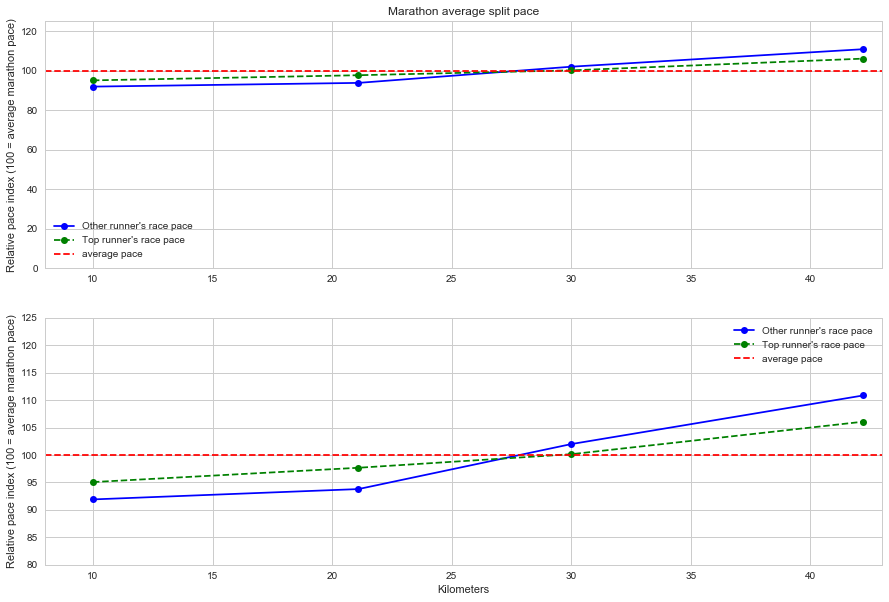

In [29]:
plt.figure(figsize=(15,10))
#Show with full y axis
plt.subplot(2,1,1)
plt.plot(xaxis, avgPace_index_other, marker = 'o', color = 'b', linestyle = 'solid', label = 'Other runner\'s race pace')
plt.plot(xaxis, avgPace_index_best, marker = 'o', color = 'g', linestyle = 'dashed', label = 'Top runner\'s race pace')
plt.ylabel("Relative pace index (100 = average marathon pace)")
plt.ylim([0, 125])
plt.xlim([8,43])
plt.axhline(y = 100, label = 'average pace', color='r', linestyle = 'dashed',)
plt.title('Marathon average split pace')
plt.legend()

#Show with shortened y axis
plt.subplot(2,1,2)
plt.plot(xaxis, avgPace_index_other, marker = 'o', color = 'b', linestyle = 'solid', label = 'Other runner\'s race pace')
plt.plot(xaxis, avgPace_index_best, marker = 'o', color = 'g', linestyle = 'dashed', label = 'Top runner\'s race pace')
plt.ylabel("Relative pace index (100 = average marathon pace)")
plt.ylim([80, 125])
plt.xlim([8,43])
plt.axhline(y = 100, label = 'average pace', color='r', linestyle = 'dashed',)
plt.xlabel('Kilometers')
plt.legend()
plt.show()

Top runners, on average, maintained a much more even pace throughout the race. Although even the top runners seem to start faster and slow as the race progresses.  While it is tempted to conclude that an even race pace is a better strategy, this is not necessarily the case as we cannot imply causality based on this data alone (for example it may be that running at such a high pace forces more even running, therefore the causality can go the other way). 

## Future Research 

Several improvements can be made to this study:
- The database can be expanded to include results across multiple years of the Toronto marathon. This will help ensure that the results aren’t skewed by something that happened in a particular year (e.g. a strong headwind in the latter part of the race). An expanded database will enable me to track individual runners over time.
- The database can be expanded to include results across multiple races with similar profiles. This can remove any bias that the Toronto marathon may have (e.g. if there is a popular marathon at the same time which attracts the best athletes away from Toronto). Again, following runners across multiple races may yield interesting results, particularly in pacing strategy (e.g. using average marathon times as a pacing benchmark rather than the actual race pace average).
- Including training data (e.g. from Strava) to predict and analyze race results is probably the area with most promise. By including training data the pacing strategies can be more effectively measured.
